# TODO

 - Embedding for all the lines of the document
 <!-- - Embeddings for all concepts -->
 <!-- - Each concept has a list of neighboring concepts based on similarity (e.g. cosine similarity) -->
 <!-- - The searched term will be embedded and compared to all concepts -->
 - The searched term will be embedded and compared to all lines of the corpus (with hashing to accelerate)
 <!-- - Return patients having the neighboring concepts of the searched term -->
 - Return patients that have big similarity

In [1]:
# %pip install -U sentence-transformers -q

### Importing

In [2]:
# ----------------------------------- tech ----------------------------------- #
import os
import glob
import pickle

# ---------------------------- Display and friends --------------------------- #
from tqdm import tqdm
from matplotlib import pyplot as plt

# ------------------------- Transformers and freinds ------------------------- #
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from sentence_transformers import SentenceTransformer, util
import torch
import torch.nn.functional as F
import numpy as np

# ------------------------ Classification and friends ------------------------ #
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE

# ----------------------------------- local ---------------------------------- #
from data_preprocessing import Get_and_process_data


### Configurations

In [66]:
lines_per_tokenization = 5
filename_split_key = "__at__"
# Load model from HuggingFace Hub
device = "cuda"
# model_checkpoint = "sentence-transformers/multi-qa-MiniLM-L6-cos-v1"
model_checkpoint = "gsarti/scibert-nli"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModel.from_pretrained(model_checkpoint)
data_path = "../data/train/txt"
embeddings_path = data_path + os.sep + "embeddings"
similarity = torch.nn.CosineSimilarity()
if not os.path.exists(embeddings_path):
    os.makedirs(embeddings_path)

### utils

In [102]:
#Mean Pooling - Take average of all tokens
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


#Encode text
def encode(texts, tokenizer = tokenizer, model= model):
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    return embeddings

def find_cluster(query_emb, clustered_data, similarity=similarity):
    best_cluster = None
    best_score = -1
    for i in clustered_data.keys():
        center = clustered_data[i]["center"]
        score = similarity(query_emb, center)
        if score >= best_score:
            best_cluster = i
            best_score = score
    return best_cluster

def text_splitter(text, lines_per_tokenization=lines_per_tokenization):
    lines = text.split("\n")
    
    texts = []
    for i in range(len(lines)//lines_per_tokenization):
        texts.append("\n".join(lines[i*lines_per_tokenization:(i+1)*lines_per_tokenization]))
        
    return texts

def semantic_search_base(query_emb, doc_emb, docs):
    #Compute dot score between query and all document embeddings
    scores = torch.mm(query_emb, doc_emb.transpose(0, 1))[0].cpu().tolist()

    #Combine docs & scores
    doc_score_pairs = list(zip(docs, scores))

    #Sort by decreasing score
    doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)
    print(doc_score_pairs)
    #Output passages & scores
    for doc, score in doc_score_pairs:
        print("==> ",score) 
        print(doc)
        
def forward(texts, tokenizer= tokenizer, model= model):
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    model_output = model(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    return embeddings


def forward_doc(texts, tokenizer= tokenizer, model= model, no_grad= False):
    texts = text_splitter(texts) 
    
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    
    # Compute token embeddings
    if no_grad:
        with torch.no_grad():
            model_output = model(**encoded_input, return_dict=True)
    else :
        model_output = model(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # NOTE: This is an easy approach
    # another mean pooling over the lines of the document
    # embeddings = torch.mean(embeddings_lines, 0).unsqueeze(0)
    
    # Normalize embeddings
    embeddings = F.normalize(embeddings,  p=2, dim=1)
    
    return embeddings


### Testing Inference from checkpoint

In [5]:
model =model.eval()

In [6]:
# Sentences we want sentence embeddings for
query = "How many people live in London?"
docs = ["Around 9 Million people live in London", "London is known for its financial district"]

#Encode query and docs
query_emb = encode(query)
doc_emb = encode(docs)

semantic_search_base(query_emb, doc_emb, docs)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


0.6644321084022522 Around 9 Million people live in London
0.49576687812805176 London is known for its financial district


0.915637195110321 Around 9 Million people live in London


0.49475765228271484 London is known for its financial district

### Testing training

In [7]:
encoded_input = tokenizer(query, padding=True, truncation=True, return_tensors='pt')
model_output = model(**encoded_input, return_dict=True)
# model_output

In [8]:
encoded_input["input_ids"].shape

torch.Size([1, 11])

In [9]:
model_output.last_hidden_state.shape

torch.Size([1, 11, 768])

In [10]:
model_output.pooler_output.shape

torch.Size([1, 768])

In [11]:
# model.train()

query = "How many people live in London?"
answer = "Around 9 Million people live in London"

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

q = forward(query)
print("q shape :", q.shape)
a = forward(answer)
print("a shape :", a.shape)

loss = loss_fn(a,q)

optimizer.zero_grad()
# loss.backward()
# optimizer.step()

q shape : torch.Size([1, 768])
a shape : torch.Size([1, 768])


### Getting data

In [78]:
doc = ""

with open("../data/train/txt/018636330_DH.txt") as f:
    doc = f.read()
    
doc_emb = forward_doc(doc)
doc_emb.shape

torch.Size([14, 768])

In [105]:
c_emb= encode("herniation with cord compression")
semantic_search_base(c_emb, doc_emb, text_splitter(doc))

[('Discharge Summary\nSigned\nDIS\nReport Status :\nSigned', 0.4251006543636322), ('C5-6 disc herniation with cord compression and myelopathy .\nPRINCIPAL PROCEDURE :\nMicroscopic anterior cervical diskectomy at C5-6 and fusion .\nHISTORY OF PRESENT ILLNESS :\nThe patient is a 63-year-old female with a three-year history of bilateral hand numbness and occasional weakness .', 0.4241237938404083), ('Within the past year , these symptoms have progressively gotten worse , to encompass also her feet .\nShe had a workup by her neurologist and an MRI revealed a C5-6 disc herniation with cord compression and a T2 signal change at that level .\nPAST MEDICAL HISTORY :\nSignificant for hypertension , hyperlipidemia .\nMEDICATIONS ON ADMISSION :', 0.38847389817237854), ('DISCHARGE SUMMARY\nNAME :\nKOTE , OA\nUNIT NUMBER :\n509-22-30', 0.31610527634620667), ('She occasionally drinks alcohol .\nPHYSICAL EXAMINATION :\nShe had 5/5 strength in bilateral upper and lower extremities .\nShe had a Hoffman

### Saving embeddings

In [106]:
# what are the elements in the folder ../data/train/txt/
all_docs = {}
text_files = glob.glob(data_path + os.sep +  "*.txt")
for file in tqdm(text_files, "Encoding documents", ascii=True):
    with open(file) as f:
        doc = f.read()
    file_name = os.path.basename(file).split(".")[0]
    embeddings = forward_doc(doc, no_grad=True)
    for i,emb in enumerate(embeddings):
        all_docs[file_name+filename_split_key+str(i)] = emb.unsqueeze(0)

Encoding documents: 100%|##########| 170/170 [06:29<00:00,  2.29s/it]


In [107]:
with open(embeddings_path + os.sep + "all_docs.pkl", "wb") as f:
    pickle.dump(all_docs, f)

In [8]:
# with open(embeddings_path + os.sep + "all_docs.pkl", "rb") as f:
#     all_docs = pickle.load(f)

### Classify the embeddings

We can use hierachical clustering to classify the embeddings for a very search efficient task. But for simplicity, we will only perform K-means clustering.

In [108]:
sample_names_list = list(map(lambda x: x[0], all_docs.items()))[:]
sample_values_list = list(map(lambda x: x[1], all_docs.items()))[:]
sample = np.array(list(map(lambda x: x.numpy().reshape(-1), sample_values_list))) # array of 1 dim vectors
sample.shape

(3218, 768)

#### Test hierachical clustering

In [93]:
clustering = AgglomerativeClustering(distance_threshold=0.7, n_clusters=None).fit(sample)

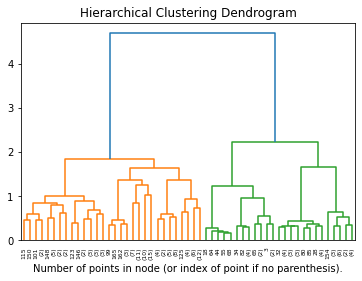

In [94]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

#### Test K-means clustering

In [109]:
clustering = KMeans(n_clusters = 10).fit(sample)

/home/mus5900/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mus5900/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


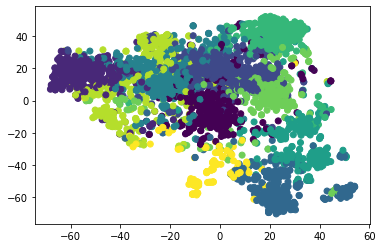

In [111]:
# Scatter plot using TSNE
def plot_clutering(sample):
    new_sample = TSNE(n_components=2).fit_transform(sample)
    plt.scatter(new_sample[:, 0], new_sample[:, 1], c=clustering.labels_)
    plt.show()
    # # plot in 3D
    # new_sample_3D = TSNE(n_components=3).fit_transform(sample)
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(new_sample_3D[:, 0], new_sample_3D[:, 1], new_sample_3D[:, 2], c=clustering.labels_)
    # plt.show()
plot_clutering(sample)

In [112]:
for i in range(10):
    print("cluster", i , "->" , list(clustering.labels_).count(i), "element")

cluster 0 -> 298 element
cluster 1 -> 337 element
cluster 2 -> 443 element
cluster 3 -> 385 element
cluster 4 -> 388 element
cluster 5 -> 335 element
cluster 6 -> 318 element
cluster 7 -> 244 element
cluster 8 -> 310 element
cluster 9 -> 160 element


In [113]:
clustered_data = {}
for i,center in enumerate(clustering.cluster_centers_):
    clustered_data[i] = {"center": torch.tensor(center.reshape(1, -1)), "elements": {}}

for i, cluster in enumerate(clustering.labels_):
    clustered_data[cluster]["elements"][sample_names_list[i]] = all_docs[sample_names_list[i]]

In [114]:
with open(embeddings_path + os.sep + "clustered_data.pkl", "wb") as f:
    pickle.dump(clustered_data, f)

### Search

In [115]:
with open(embeddings_path + os.sep + "clustered_data.pkl", "rb") as f:
    clustered_data = pickle.load(f)

In [116]:
center = clustered_data[0]["center"]

In [117]:
similarity(query_emb, center)

tensor([0.3966])

In [138]:
# query = "DIGOXIN and AMIODARONE HCL"
query = "HEENT showed tongue with laceration on the right edge"
query_emb = encode(query)

cluster = find_cluster(query_emb, clustered_data)
best_score = -1
best_doc = None
for name, doc_emb in clustered_data[cluster]["elements"].items():
    score = similarity(query_emb, doc_emb)
    # print(name, "\t{:.2f}".format(float(score)))
    if score >= best_score:
        best_doc = name
        best_score = score
print(best_doc)
print(best_score)

record-124__at__10
tensor([0.5548])


In [ ]:
# model_checkpoint = "allenai/scibert_scivocab_uncased"
# batch_size = 32
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


# data_loader = Get_and_process_data(tokenizer, train_split=0.95, add_unlabeled=True)
# D = data_loader.get_dataset()
# label_list = data_loader.get_label_list()